In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import lightgbm 
from lightgbm import LGBMRegressor

### 1.Load Data 

In [8]:
data_clean = pd.read_csv('data_clean.csv') 

n_sample=80000
data_clean= data_clean.sample(n_sample, random_state=101).reset_index()
data_clean.drop(['Unnamed: 0','index','weekday'],axis=1, inplace=True)

### 2. StandarScaler

In [9]:
sc= StandardScaler()
data_scaled = sc.fit_transform(data_clean[['distance','temp', 'clouds', 
                                   'pressure', 'rain', 'humidity', 'wind']])
data_scaled = pd.DataFrame(data_scaled, columns=['distance', 'temp', 'clouds',
                                                 'pressure', 'rain', 'humidity', 'wind'])
data_notscaled= data_clean.drop(columns= ['distance','temp', 'clouds', 'pressure', 
                                  'rain', 'humidity', 'wind']).reset_index(drop=True)  
df= pd.concat([data_scaled,data_notscaled],axis=1)
df= pd.get_dummies(data=df, columns=['hour'],drop_first=True)

### 3. Modelling Preparation  

In [10]:
#set target and features
y= df['price']
x= df.drop(['price'], axis=1)

#split data to train and test  
X_train, X_test, y_train, y_test = train_test_split(x, y ,test_size = 0.2,random_state=101)

In [11]:
#function for evaluating model  
def evalmetrics(model, x, y):
    prediction = model.predict(x)
    MAE=(round(mean_absolute_error(y,prediction),2))
    RMSE=(round(np.sqrt(mean_squared_error(y,prediction)),2))
    R2=(round((r2_score(y,prediction)),3))
    evalscore = pd.DataFrame([{'MAE': MAE,'RMSE':RMSE,'R2' : R2}],index=[':'],)
    return evalscore


## 1. Linear Regression 

In [9]:
LR = LinearRegression()
LR.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [10]:
train_error= evalmetrics (LR, X_train, y_train)
test_error= evalmetrics (LR, X_test, y_test)
pd.concat([train_error,test_error],keys=['Train','Test'])



,,MAE,RMSE,R2
Train,:,1.94,3.03,0.895
Test,:,1.97,3.11,0.891


### 2. Support Vector Regression

In [15]:
SVR_model = SVR()
SVR_model.fit(X_train, y_train)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [16]:
train_error1= evalmetrics (SVR_model, X_train, y_train)
test_error1= evalmetrics (SVR_model, X_test, y_test)
pd.concat([train_error1,test_error1],keys=['Train','Test'])


,,MAE,RMSE,R2
Train,:,1.48,2.85,0.907
Test,:,1.60,2.97,0.900


#### The score better than the linear regression, SVR has managed to lower the mean absolute error as well 


### 3. Random Forest Regressor

In [11]:
RFR = RandomForestRegressor()
RFR.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [12]:
train_error2= evalmetrics (RFR, X_train, y_train)
test_error2= evalmetrics (RFR, X_test, y_test)
pd.concat([train_error2,test_error2],keys=['Train','Test'])

,,MAE,RMSE,R2
Train,:,0.57,1.03,0.988
Test,:,1.55,2.81,0.911


### 4. XGB Regressor

In [13]:
XGB_params1 = {'objective': 'reg:squarederror','colsample_bytree' : 0.4, 'learning_rate' : 0.09,
                'max_depth' : 4, 'alpha' : 0.5, 'n_estimators' : 200, 'gamma': 0.5, 'reg_lambda':0.5 }

               
XGB = XGBRegressor(**XGB_params1)

XGB.fit(X_train, y_train)


XGBRegressor(alpha=0.5, base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.4, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.09, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=200, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0.5,
             reg_lambda=0.5, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [14]:
train_error3= evalmetrics (XGB, X_train, y_train)
test_error3= evalmetrics (XGB, X_test, y_test)
pd.concat([train_error3,test_error3],keys=['Train','Test'])

,,MAE,RMSE,R2
Train,:,1.52,2.62,0.921
Test,:,1.57,2.73,0.916


### 5. LightGBM Regressor

In [18]:
LGBM_params = {'objective': 'regression',
                'metric': ['l2', 'mae'],'learning_rate': 0.005,"max_depth": 4,
               "num_leaves": 40,"max_bin": 50,"n_estimators": 500, "reg_alpha" :0.8, "reg_lambda": 0.5}
LGBM = LGBMRegressor(**LGBM_params)
LGBM.fit(X_train, y_train)


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.005, max_bin=50,
              max_depth=4, metric=['l2', 'mae'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=500,
              n_jobs=-1, num_leaves=40, objective='regression',
              random_state=None, reg_alpha=0.8, reg_lambda=0.5, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [18]:
train_error4= evalmetrics (LGBM, X_train, y_train)
test_error4= evalmetrics (LGBM, X_test, y_test)
pd.concat([train_error4,test_error4],keys=['Train','Test'])



,,MAE,RMSE,R2
Train,:,2.70,3.79,0.835
Test,:,2.76,3.90,0.829


By comparing all the model by RMSE, it can be concluded that, even though all the model has MAE between 14% - 20%, Random Forest and XGBoost Regressor have the lowest RMSE for test data. Let's validate the findings with Kfold.

### Kfold Validation  

In [23]:
def regression_model(n_cv):
    LR= LinearRegression()
    RFR= RandomForestRegressor()
    LGBM = LGBMRegressor(**LGBM_params)
    XGB = XGBRegressor(**XGB_params1)
    model_name = ['LR', 'RFR', 'LGBM', 'XGB']
    models = [LR, RFR, LGBM, XGB]
    score = []
    for item in models:
        rmse = []
        mae = []
        R2 = []
        kf = KFold(n_splits=n_cv,shuffle=True)
        for train_index , test_index in kf.split(x,y):
            X_train,X_test,y_train,y_test = x.iloc[train_index],x.iloc[test_index],y.iloc[train_index],y.iloc[test_index]
            model = item
            model.fit(X_train,y_train)
            prediction = model.predict(X_test)
            mae.append(round(mean_absolute_error(y_test,prediction),2))
            rmse.append(round(np.sqrt(mean_squared_error(y_test,prediction)),2))
            R2.append(round(r2_score(y_test,prediction),2))
        temp = [
            sum(mae)/n_cv,
            sum(rmse)/n_cv,
            sum(R2)/n_cv
        ]
        score.append(temp)
    return pd.DataFrame(score,columns=['MAE','RMSE','R2'],index=model_name)

In [24]:
regression_model(5)

,MAE,RMSE,R2
LR,1.948,3.052,0.892
RFR,1.528,2.738,0.912
LGBM,2.712,3.810,0.836
XGB,1.548,2.672,0.920


The Finding of validation test give the same result with the earlier conclusion. The next step is tunning the parameter of selected method with the help of Randomized Search CV in order to optimize the performance both of the model and get the best parameter.   

### Tunning with Randomized Search CV

### 1. XGB 

In [22]:
XGB_params2 = {'objective' :'reg:squarederror','colsample_bytree': np.linspace(0.3, 0.7),
          'gamma': np.linspace(0, 0.5),
          'learning_rate': np.linspace(0.003, 0.3), # default 0.1 
          'max_depth': np.linspace(2, 6), # default 3
          'n_estimators': np.linspace(100, 250), # default 100
          'subsample': np.linspace(0.4, 0.6), 'reg_lambda': np.linspace(0,1)}

XGB_randomized = XGBRegressor()
xgb_search = RandomizedSearchCV(XGB_randomized,param_distributions=XGB_params2, 
                                random_state=42, n_iter=50, cv=8, verbose=1, n_jobs=1, return_train_score=True)
XGB_randomized.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

In [23]:
train_error5= evalmetrics (XGB_randomized, X_train, y_train)
test_error5= evalmetrics (XGB_randomized, X_test, y_test)
pd.concat([train_error5,test_error5],keys=['Train','Test'])


,,MAE,RMSE,R2
Train,:,1.27,2.16,0.946
Test,:,1.47,2.65,0.921


### 2. Random Forest Regressor

In [26]:
RFR_randomized = RandomForestRegressor()
RFR_randomized.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [28]:
RFR_params = {
    'min_samples_split': range(3,10),
    'n_estimators': range(10,100, 10),
    'max_features': ['auto', 'sqrt', 'log2']
}


In [29]:
RFR_randomized = RandomizedSearchCV(
                estimator =  RFR_randomized, param_distributions = RFR_params, 
                cv = 10, random_state=11, n_iter=30, scoring='neg_mean_squared_error')
RFR_randomized.fit(X_train, y_train)
RFR_randomized.best_params_

{'n_estimators': 80, 'min_samples_split': 9, 'max_features': 'auto'}

In [30]:
train_error6= evalmetrics (RFR_randomized, X_train, y_train)
test_error6= evalmetrics (RFR_randomized, X_test, y_test)
pd.concat([train_error6,test_error6],keys=['Train','Test'])



,,MAE,RMSE,R2
Train,:,0.85,1.60,0.971
Test,:,1.53,2.76,0.914


In [31]:
pred = pd.DataFrame({'y actual' : y_test , 'y predicted' : RFR_randomized.predict(X_test)})
pred['difference'] = round(pred['y actual'] - pred['y predicted'])
sel = pred.sort_values(by='difference',ascending=False)
sel.head(50)

,y actual,y predicted,difference
41595,75.0,35.425671,40.0
11889,62.5,22.786104,40.0
53188,80.0,45.209878,35.0
28695,73.5,39.899981,34.0
44626,65.0,31.816494,33.0
33059,65.0,33.968034,31.0
46438,65.0,33.942074,31.0
50506,52.5,22.149464,30.0
36455,47.5,18.270803,29.0
10292,65.0,36.472735,29.0


#### Regression Plot between the actual and predicted prices to see how well the regression line fits tha data.

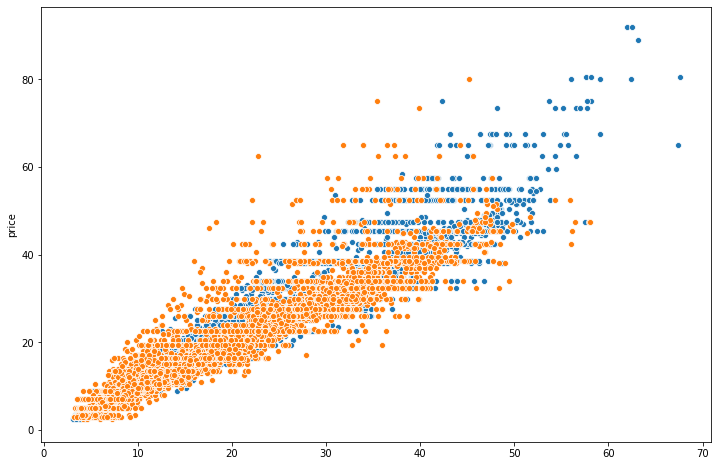

In [56]:
plt.figure(figsize=(12,8))
sns.scatterplot(RFR_randomized.predict(X_train),y_train)
sns.scatterplot(RFR_randomized.predict(X_test),y_test, )

The residual plot for test data looks similar to the train data which is a really a good sign.
We can see that the major percent of data lies within the price range which is the same as train data, spread around 0 and 60. Beside that, there are a few outliers which is quite normal when the model is exposed to data outside the training data set.


Feature Importance

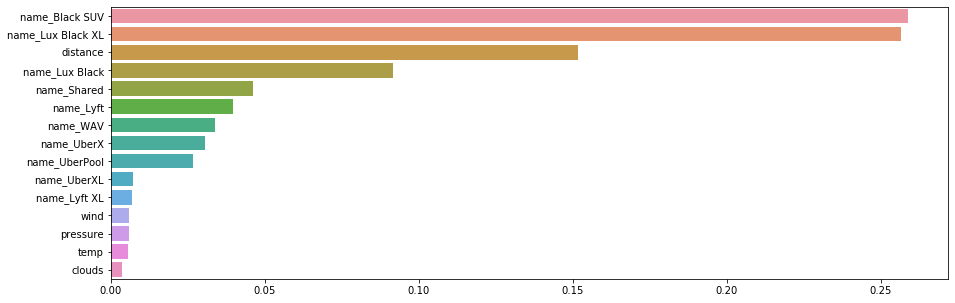

In [47]:
plt.figure(figsize=(15,5))
feature_importance = pd.Series(RFR_randomized.best_estimator_.feature_importances_,index=x.columns).sort_values(ascending=False).head(15)
sns.barplot(x=feature_importance.values , y = feature_importance.index)

Clearly the important features that affect the price of Uber or Lyft are the the type of car and price.

In [48]:
import pickle

In [49]:
filename = 'final_model.sav'
pickle.dump(RFR_randomized, open(filename, 'wb'))

In [52]:
filename = 'x_dummies_colomn.sav'
pickle.dump(df.columns, open(filename , 'wb'))

In [54]:
filename = 'real_colomn.sav'
pickle.dump(df.drop('price',axis=1).columns, open(filename , 'wb'))